# 02. Neural Network Classification with Pytorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options)

In [1]:
## 1. Make Classification Data and Get it ready

In [2]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000
# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)


In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({'X1': X[:,0],
                        'X2': X[:,1],
                        'label':y})

circles.head(5)


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [6]:
circles['label'].value_counts() 


label
1    500
0    500
Name: count, dtype: int64

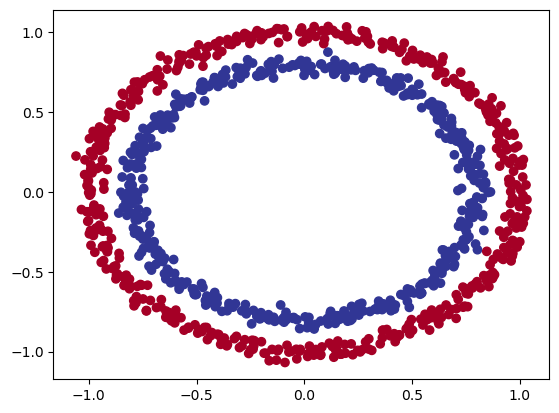

In [7]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

**Note:** The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals

### 1.1 Check input and output shapes     

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

### 1.2 Turn data into tensors and create train and test splits

In [9]:
import torch

In [10]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [11]:
# turn data -> tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [12]:
type(X), X.dtype

(torch.Tensor, torch.float32)

In [13]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 = 20% of data will be test & 80% will be train
                                                    random_state=42)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building The Model

Let's build a model to classify our blue and red dots

Steps:
1. Setup device agonistic code so our code will run on an accelerator
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer 
4. Creat a training and test loop

In [15]:
!nvidia-smi

Mon Dec 30 15:36:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.07                 Driver Version: 566.07         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8              1W /  105W |      15MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [16]:
from torch import nn

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Create a model that:

1. Subclasses `nn.Module` (almost all models in Pytorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass ()

In [17]:
device

'cuda'

In [18]:
torch.cuda.empty_cache()


In [19]:
# 1. Construct a Model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscale to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features and outputs a single feature (same shape as y)
    
    # 3. Define a forward() method that outlines the forward pass 
    def forward(self, x):
        return self.layer_2(self.layer_1(x) ) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of out model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0 

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
# Replicate the model above using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1264,  0.3608],
                      [ 0.5421,  0.6129],
                      [ 0.1842,  0.4278],
                      [-0.0221,  0.6291],
                      [ 0.5966, -0.3501]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.4306, -0.3865,  0.3360,  0.0272,  0.1188], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0729, -0.1336, -0.2028, -0.3603,  0.3565]], device='cuda:0')),
             ('1.bias', tensor([-0.3312], device='cuda:0'))])

In [22]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

print(len(untrained_preds),untrained_preds.shape )
len(X_test), X_test.shape
untrained_preds[:10]
# y_test[:10]

200 torch.Size([200, 1])


tensor([[-0.6590],
        [-0.7563],
        [-0.1998],
        [-0.7900],
        [ 0.1244],
        [ 0.0625],
        [-0.4683],
        [-0.2758],
        [-0.2142],
        [-0.7592]], device='cuda:0')

### 2.1 Setup loss function & optimizer

For regression you might want MAE or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy (cross entropy)

**Reminder:** Loss function measures how wrong your models predict are

**Optimizers** Two of the most common & useful are SGD and Adam, however Pytorch has many built-in options

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`

In [23]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [24]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc =  (correct/len(y_pred) ) * 100
    return acc

    

## 3. Train Model

To train our model, we're going to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer 0 grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

In [25]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

## Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be logits
We can convert these logits -> prediction probabilities by passing them to some kind of activation funtion (e.g sigmoid for binary classification and softmax for multiclass classification )

Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the `argmax()`

In [26]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.6590],
        [-0.7563],
        [-0.1998],
        [-0.7900],
        [ 0.1244]], device='cuda:0', grad_fn=<SliceBackward0>)

In [27]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3410],
        [0.3195],
        [0.4502],
        [0.3122],
        [0.5311]], device='cuda:0', grad_fn=<SigmoidBackward0>)

For our prediction probability values, we need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5, y = 1 (class 1)
* `y_pred_probs` < 0.5, y = 0 (class 0)

In [28]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

### 3.2 Building A Training and Testing Loop

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training an evaluation loop
for epoch in range(epochs):
    # Training
    model_0.train()
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logtis -> pred probs -> pred labels
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Optimizer step (gradient descent)
    optimizer.step()
    
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, # nn.BCEWithLogits
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc:  {acc:.2f}% | Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%")
        

Epoch: 0 | Loss: 0.71780, Acc:  46.38% | Test loss: 0.70721, Test accuracy: 49.50%
Epoch: 10 | Loss: 0.70845, Acc:  47.62% | Test loss: 0.69923, Test accuracy: 51.50%
Epoch: 20 | Loss: 0.70341, Acc:  48.25% | Test loss: 0.69543, Test accuracy: 49.50%
Epoch: 30 | Loss: 0.70043, Acc:  48.25% | Test loss: 0.69358, Test accuracy: 50.00%
Epoch: 40 | Loss: 0.69851, Acc:  49.12% | Test loss: 0.69268, Test accuracy: 50.00%
Epoch: 50 | Loss: 0.69720, Acc:  49.00% | Test loss: 0.69229, Test accuracy: 50.00%
Epoch: 60 | Loss: 0.69625, Acc:  49.38% | Test loss: 0.69215, Test accuracy: 50.50%
Epoch: 70 | Loss: 0.69554, Acc:  49.38% | Test loss: 0.69217, Test accuracy: 48.50%
Epoch: 80 | Loss: 0.69501, Acc:  49.38% | Test loss: 0.69226, Test accuracy: 49.00%
Epoch: 90 | Loss: 0.69459, Acc:  49.38% | Test loss: 0.69240, Test accuracy: 50.50%


## 4. Make Predictions and Evaluate the model

As the result from the metrics our model isn't learning anything ...

So to inspect it, let's make some predictions and make them visual!

To do so, we're going to import a function called `plot_decision_boundary()`


In [30]:
import requests
from pathlib import Path

# Download helper functions from Learn Pytorch repo (if it's not already downloaded)
if Path('helper_functions.py').is_file():
    print("File already exists")
else:
    print("Downloading helper functions.py")
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
    with open("helper_functions.py","wb") as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary

File already exists


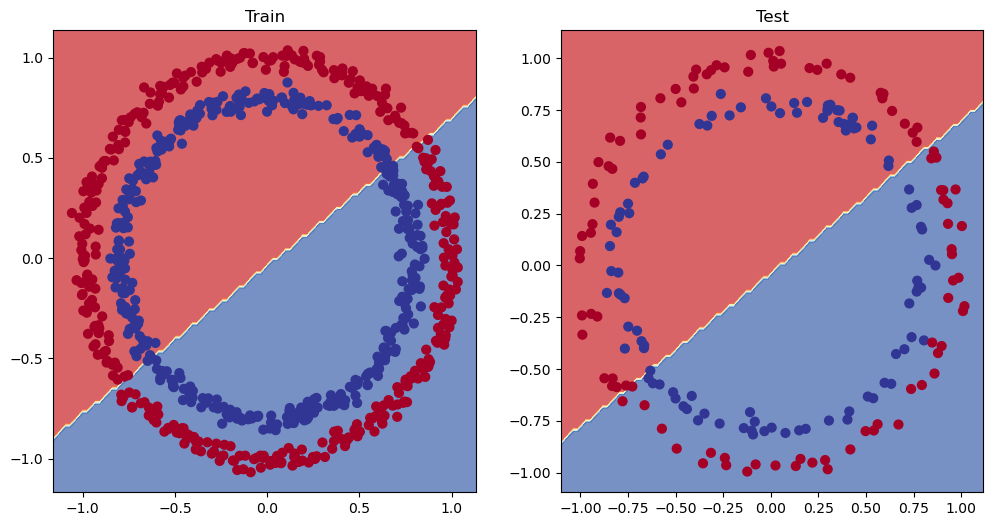

In [31]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving The Model (Model Perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units 
* Fit for longer
* Changing the activation functions
* Adjust the learning rate
* Change the loss function

These options are all from a Model's Perspective bc they deal directly with the model, rather than the data (data perspective).

And bc these options are all values we (as machine learning engineers & data scientists) can change, they are referred as **hyperparameters**

Improve our model by:
* Hidden units: 5 -> 10
* Number of layers: 2 -> 3
* Number of epochs: 100 -> 1000

In [32]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x))) # This way of writing operations leverages speed ups where possible behind the scenes 
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [34]:
# Create the loss func
loss_fn = nn.BCEWithLogitsLoss()

# Create the optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)


In [35]:
# Write the training loop for model_1
torch.manual_seed(42)

epoch = 1000 # Train for longer

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probability -> prediction labels
    
    # 2. Calculate the loss/acc 
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward (backpropagation)
    loss.backward()
     
    # 5. Optimizer step (gradient descent)
    optimizer.step()
    
    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate the loss
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc:  {acc:.2f}% | Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%")
        


Epoch: 0 | Loss: 0.69396, Acc:  50.88% | Test loss: 0.69261, Test accuracy: 51.00%


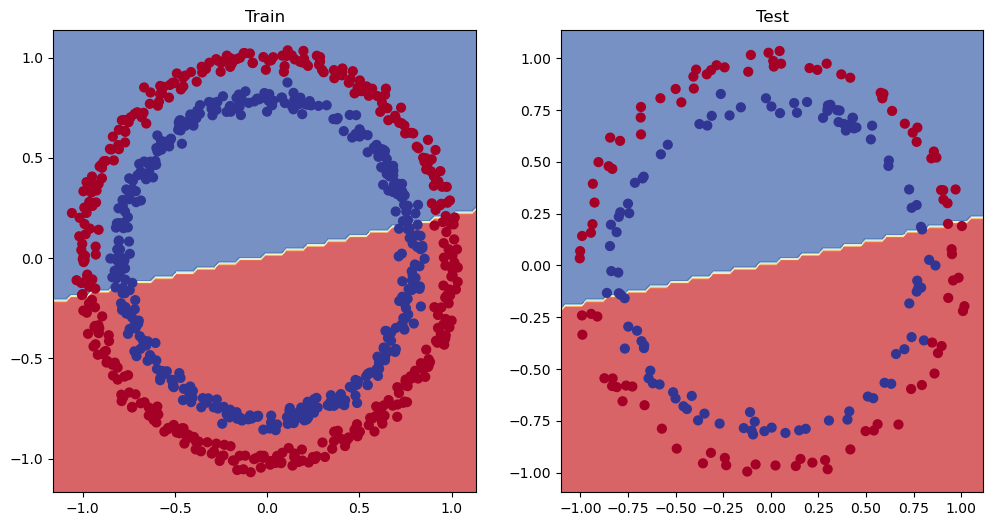

In [36]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot is to test out a smaller problem

In [37]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [38]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


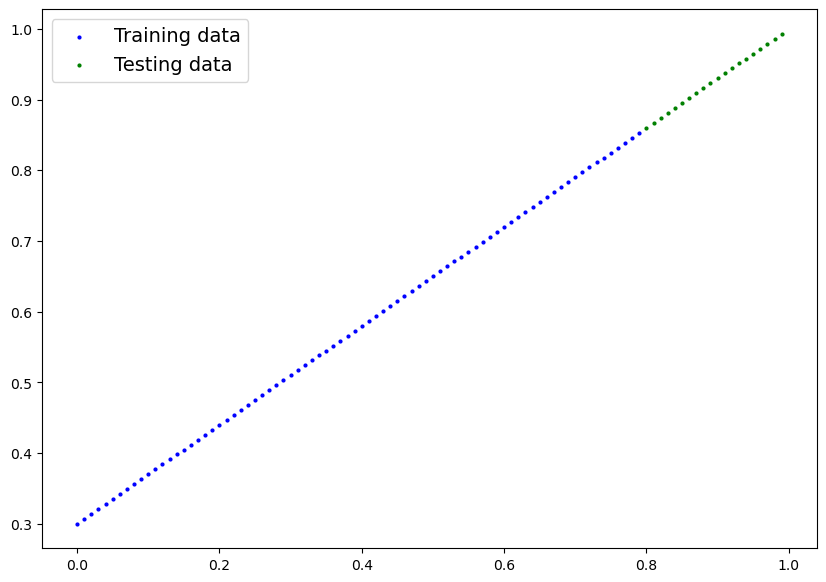

In [39]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

### 5.2 Adjusting `model_1` to fit a straight line

In [40]:

# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [42]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05599, Test loss: 0.01426
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


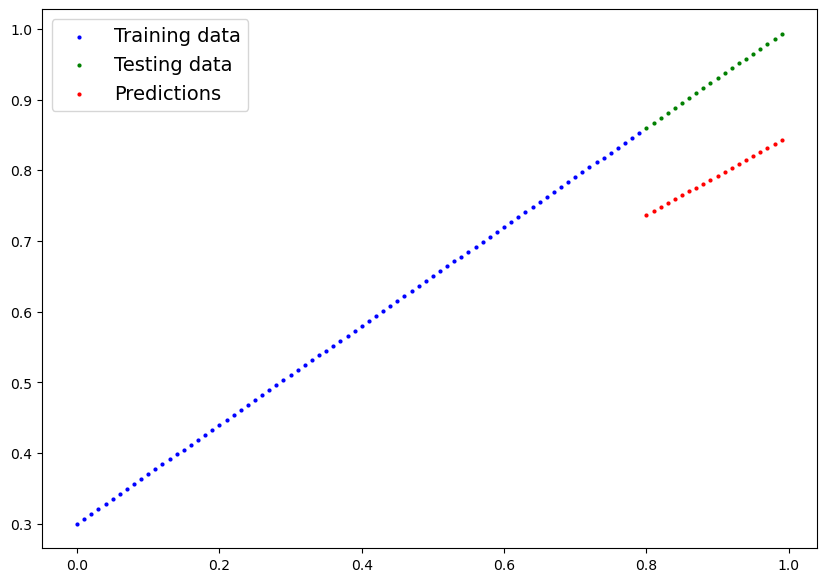

In [43]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)
    
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                test_data=X_test_regression.cpu(),
                test_labels=y_test_regression.cpu(),
                predictions=y_preds.cpu())

## 6. The Missing piece: Non-linearity:

What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?

Or in machine learning terms, an infinite (but really it is infinite) of linear and non-linear functions?



### 6.1 Recreating non-linear data (red n blue circles)

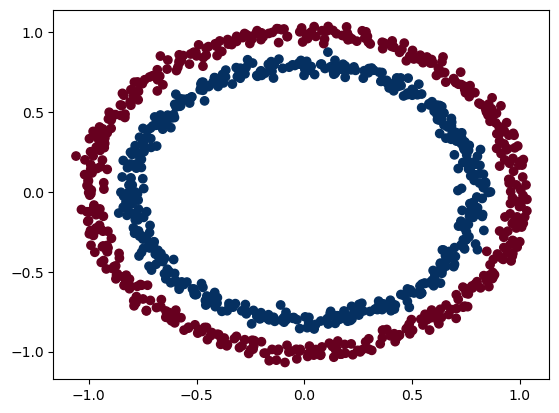

In [44]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdBu)

In [45]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a Model with non-linearity

* Linear: Straight lines
* Non-linear = Non-straight lines

Artificial neural network are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data

In [46]:
# Build a Model with non-linear activation funtions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # Relu is a non-linear activation
        
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [47]:
# Setup loss & optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

### 6.3  Training the Model with non-linearity

In [48]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


### 6.4 Evaluating the Model trained with non-linear activation functions

In [49]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
    
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

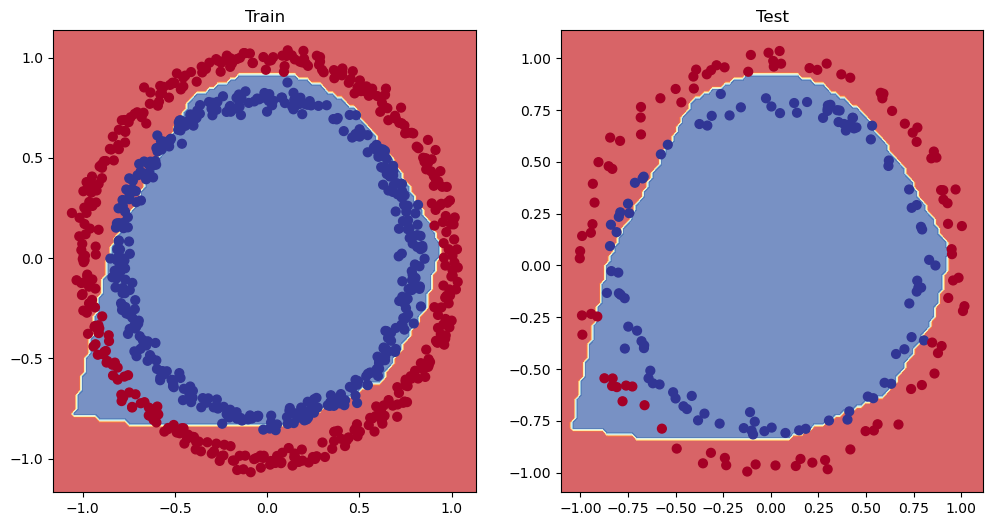

In [50]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own

and these tools are linear & non-linear functions

In [51]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [52]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

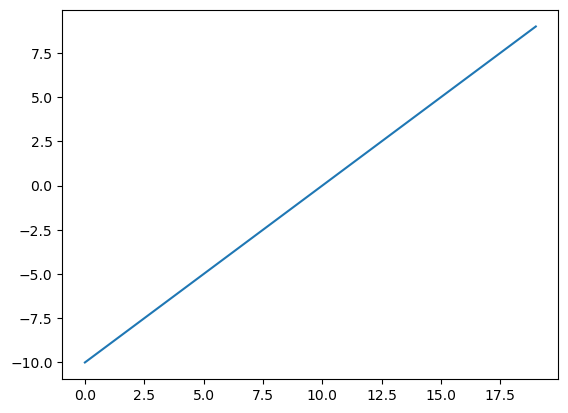

In [53]:
# Visualize the tensor
plt.plot(A)

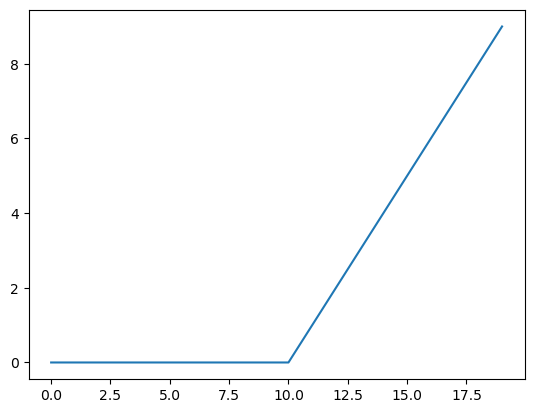

In [54]:
plt.plot(torch.relu(A))

In [55]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0),x) # inputs must be tensors
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

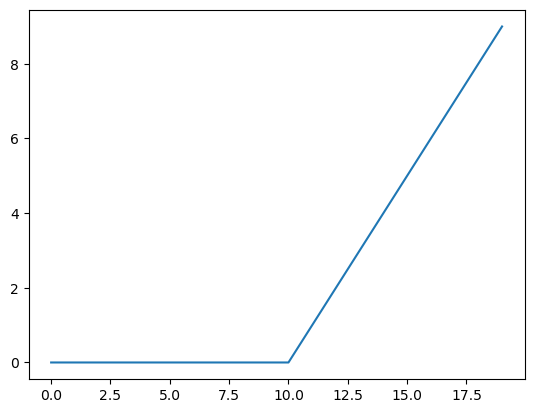

In [56]:
# Plot ReLU activation function
plt.plot(relu(A))

In [57]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))


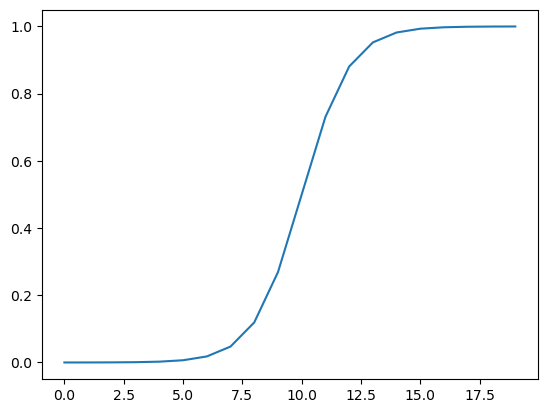

In [58]:
plt.plot(torch.sigmoid(A))

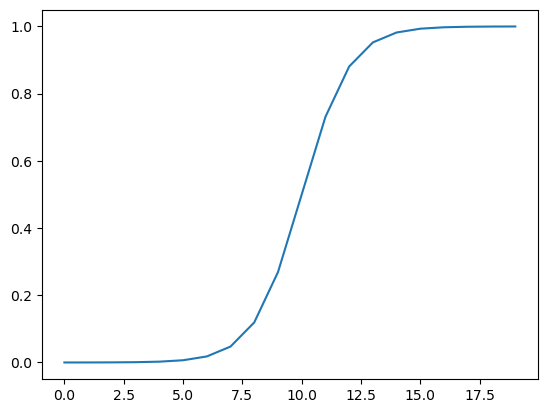

In [59]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classification = 1 thing or another (cat vs dog, spam vs not spam, fraud or not fraud)
* Multi-class classification = > 1 thing or another (cat, dog vs chicken)

### 8.1 Creating a toy multi-class dataset

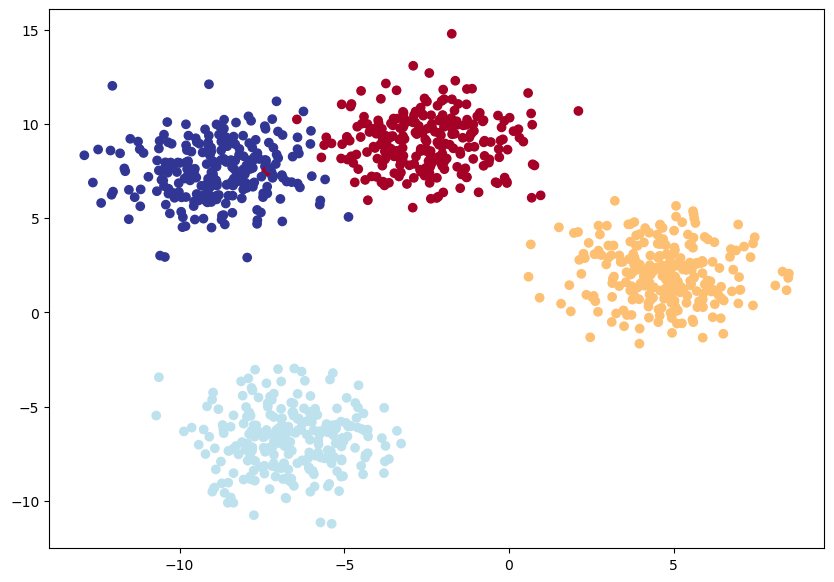

In [82]:
# Import dependencies
import torch
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
num_classes = 4
num_features = 2
random_seed = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=num_features,
                            centers=num_classes,
                            cluster_std=1.5, # Give the clusters a little shake up
                            random_state=random_seed)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train & test 
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=random_seed)

# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building A Multi-class Classification Model in Pytorch

In [83]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        ''' 
        hidden_units : Number of hidden units between layers, default is 8
        '''
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for the multi-class Classification model

In order to evaluate, train n test our model, we need to convert our model's outputs (logits) to prediction prob and then to prediction labels

Logits (raw model's output) -> Pred probs -> Pred labels

In [84]:
# Create a loss funtion for multi-class classification - measure hw wrong model's predictions are
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification - update model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting Prediction Prob for the Multi-class Pytorch Model

In [85]:
model_4.eval()
with torch.inference_mode():
   y_logits = model_4(X_blob_test.to(device))
   
y_logits[:10]

tensor([[ 0.4360, -0.2618, -0.1064,  0.1442],
        [ 0.0474, -0.9387, -0.4596, -0.0438],
        [ 0.0039, -1.1604, -0.6468,  0.3537],
        [ 0.4114, -0.2208, -0.0243,  0.1781],
        [ 0.2839, -0.6175, -0.3745,  0.0810],
        [ 0.0189, -1.0274, -0.5459, -0.0609],
        [ 0.0268, -1.1117, -0.6128,  0.3207],
        [ 0.1638, -0.7901, -0.4107,  0.0460],
        [-0.0280, -1.1786, -0.6808,  0.4976],
        [ 0.2113, -0.7195, -0.3923,  0.0607]], device='cuda:0')

In [86]:
# Convert our model's logit outputs to prediction prob
y_pred_probs = torch.softmax(y_logits, dim=1)
y_logits[:5], y_pred_probs[:5]

(tensor([[ 0.4360, -0.2618, -0.1064,  0.1442],
         [ 0.0474, -0.9387, -0.4596, -0.0438],
         [ 0.0039, -1.1604, -0.6468,  0.3537],
         [ 0.4114, -0.2208, -0.0243,  0.1781],
         [ 0.2839, -0.6175, -0.3745,  0.0810]], device='cuda:0'),
 tensor([[0.3539, 0.1761, 0.2057, 0.2643],
         [0.3462, 0.1292, 0.2085, 0.3161],
         [0.3075, 0.0960, 0.1604, 0.4362],
         [0.3367, 0.1789, 0.2178, 0.2666],
         [0.3650, 0.1482, 0.1889, 0.2979]], device='cuda:0'))

In [87]:
# Convert our model's prediction prob to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([0, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3,
        3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 0, 0, 0, 3,
        3, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3,
        3, 3, 0, 0, 3, 3, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 3, 0,
        3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 3, 0, 0, 3, 3, 0, 0,
        0, 0, 3, 0, 0, 0, 3, 0], device='cuda:0')

### 8.5 Creating a training loop and testing loop for a multi-class Pytorch model

In [90]:
# Fit the model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100
 
# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
    ### Training
    model_4.train()
    
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward() # performs backpropagation
    optimizer.step() # Updates the model's parameters
    
    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_preds)
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 0.0282, Accuracy: 99.12% | Test Loss: 0.0182, Test Accuracy: 99.50%
Epoch: 10 | Loss: 0.0278, Accuracy: 99.12% | Test Loss: 0.0178, Test Accuracy: 99.50%
Epoch: 20 | Loss: 0.0274, Accuracy: 99.25% | Test Loss: 0.0173, Test Accuracy: 99.50%
Epoch: 30 | Loss: 0.0271, Accuracy: 99.25% | Test Loss: 0.0170, Test Accuracy: 99.50%
Epoch: 40 | Loss: 0.0268, Accuracy: 99.25% | Test Loss: 0.0166, Test Accuracy: 99.50%
Epoch: 50 | Loss: 0.0266, Accuracy: 99.25% | Test Loss: 0.0163, Test Accuracy: 99.50%
Epoch: 60 | Loss: 0.0263, Accuracy: 99.25% | Test Loss: 0.0161, Test Accuracy: 99.50%
Epoch: 70 | Loss: 0.0261, Accuracy: 99.25% | Test Loss: 0.0158, Test Accuracy: 99.50%
Epoch: 80 | Loss: 0.0260, Accuracy: 99.25% | Test Loss: 0.0156, Test Accuracy: 99.50%
Epoch: 90 | Loss: 0.0258, Accuracy: 99.25% | Test Loss: 0.0154, Test Accuracy: 99.50%


### 8.6 Making and Evaluating predictions with Pytorch multi-class model

In [91]:
#  Make predictions 
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    
# View the first 10 predictions 
y_logits[:10]


tensor([[  2.0699,   9.0857,  -3.6888,  -3.3405],
        [ -1.1565,  -7.9283,  -2.1715,   6.4698],
        [-11.1362,  -0.2940,   9.8056,  -0.2918],
        [  0.4090,   6.2881,  -1.5671,  -2.2022],
        [  7.8712,   1.2180,  -9.2809,  -0.6755],
        [ -2.1795, -10.0072,  -1.8253,   8.1359],
        [ -9.7778,   1.1977,   8.7862,  -1.3928],
        [  7.4528,  -0.8233,  -8.8322,   0.1464],
        [-13.4851,  -3.8319,  11.6120,   1.8974],
        [  7.6201,  -0.3580,  -8.8754,  -0.0922]], device='cuda:0')

In [92]:
# Go from logits -> prediction prob
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[8.9677e-04, 9.9910e-01, 2.8294e-06, 4.0085e-06],
        [4.8716e-04, 5.5811e-07, 1.7654e-04, 9.9934e-01],
        [8.0358e-10, 4.1090e-05, 9.9992e-01, 4.1181e-05],
        [2.7879e-03, 9.9662e-01, 3.8641e-04, 2.0476e-04],
        [9.9852e-01, 1.2879e-03, 3.5504e-08, 1.9388e-04],
        [3.3117e-05, 1.3199e-08, 4.7194e-05, 9.9992e-01],
        [8.6599e-09, 5.0594e-04, 9.9946e-01, 3.7935e-05],
        [9.9907e-01, 2.5429e-04, 8.4549e-08, 6.7062e-04],
        [1.2602e-11, 1.9622e-07, 9.9994e-01, 6.0387e-05],
        [9.9921e-01, 3.4265e-04, 6.8511e-08, 4.4695e-04]], device='cuda:0')

In [93]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [94]:
# Go from pred probs -> pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

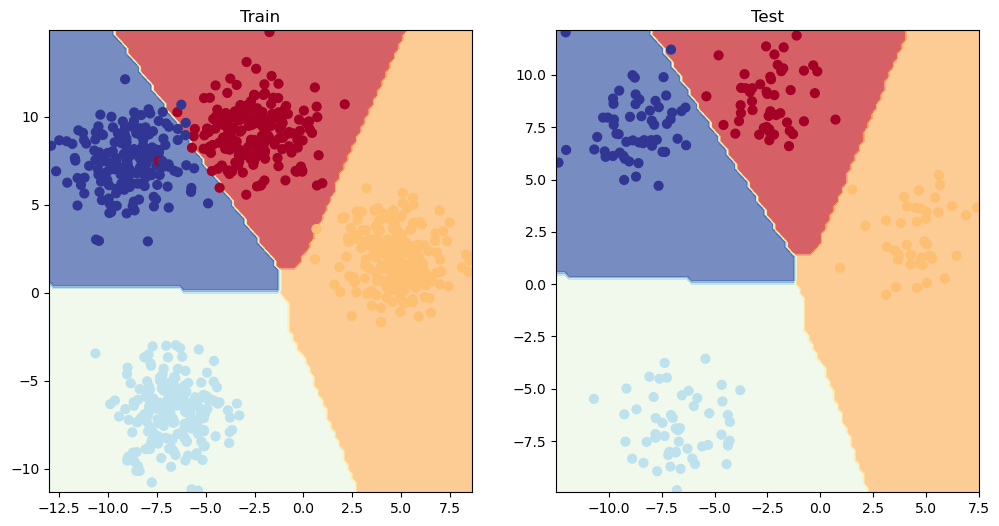

In [95]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. Classification Metrics ... (To Evaluate our Classification Model)

* Accuracy - out of 100 samples, How many does the model get right?
* Precision 
* Recall
* F1-Score
* Confusion Matrix
* Classification Matrix

If you want to access to a lot of Pytorch metrics do this

In [96]:
!pip install torchmetrics

  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.4 kB)
  Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.2 kB)
   ---------------------------------------- 0.0/927.3 kB ? eta -:--:--
   - -------------------------------------- 41.0/927.3 kB 2.0 MB/s eta 0:00:01
   ---- ----------------------------------- 102.4/927.3 kB 1.5 MB/s eta 0:00:01
   --------- ------------------------------ 225.3/927.3 kB 2.0 MB/s eta 0:00:01
   -------------------- ------------------- 481.3/927.3 kB 2.7 MB/s eta 0:00:01
   ---------------------- ----------------- 532.5/927.3 kB 2.8 MB/s eta 0:00:01
   ------------------------------ --------- 716.8/927.3 kB 2.7 MB/s eta 0:00:01
   ---------------------------------------  921.6/927.3 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 927.3/927.3 kB 2.9 MB/s eta 0:00:00
Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl (228.5 MB)
Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl (3.5 MB)


In [100]:
from torchmetrics import Accuracy

# Setup metrics
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate acc
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')